# Tutorial 5: Multi-sample integration of spatial ATAC mouse embryo samples across different developmental stages

The [spatial ATAC mouse embryo datasets](https://www.nature.com/articles/s41587-022-01603-9) measured the spatial ATAC-seq profiles of samples from E12.5, E13.5 and E15.5.

In [1]:
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import episcanpy.api as epi
from PRESENT import peak_sets_alignment, PRESENT_BC_function

warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(4,4), facecolor="white")

In [2]:
## Load spatial ATAC-seq data from multiple developmental stages
adata_list = []
for stage in ["E15.5-S1", "E13.5-S1", "E12.5-S1"]:
    cdata = sc.read_h5ad(f"Data/{stage}.h5ad")
    cdata.obs["sample"] = stage
    adata_list.append(cdata)
## feature sets unification
adata_list = peak_sets_alignment(adata_list)
adata = adata_list[0].concatenate(adata_list[1:])
print(adata)

Peak merged
Peak filtered
Matrix merged
AnnData object with n_obs × n_vars = 8680 × 248047
    obs: 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'y', 'x', 'pixel_y', 'pixel_x', 'section', 'sample', 'age', 'clusters', 'annotated_integrated_cl', 'batch'
    obsm: 'spatial'


## Run PRESENT model

In [3]:
adata = PRESENT_BC_function(
    spatial_key = "spatial", ## obsm key under which to load the spatial matrix of spots
    batch_key = "sample", ## obs key under which to load the batch indices of spots
    adata_atac = adata, ## The ATAC raw fragment count matrix of spots in anndata.AnnData format
    peak_min_cells_fraction = 0.005, ## Minimum fraction of cells accessible required for a peak to pass filtering
    nclusters = adata.obs["clusters"].nunique(),
    device = "cuda", ## Device used for training: cuda or cpu
    device_id = 4
)
print(adata)

Loading data and parameters...
Input data has been loaded


First-stage trains basic model:  22%|█▉       | 22/100 [05:01<17:47, 13.69s/it, NLL_loss=0.0759, BNN_loss=0.603, MSE_loss=0.513, ES counter=20, ES patience=20]


Early stop the first-stage training process


Second-stage trains BC model:  23%|▏| 23/100 [16:27<55:04, 42.92s/it, IBA_loss=1.73, IBP_loss=0.284, DISC_loss=1.13, GEN_loss=-1.12, ES counter=10, ES patience


Early stop the second-stage training process
Succeed to find 11 clusters at resolution 1.125
AnnData object with n_obs × n_vars = 8680 × 50
    obs: 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'y', 'x', 'pixel_y', 'pixel_x', 'section', 'sample', 'age', 'clusters', 'annotated_integrated_cl', 'batch', 'nb_features', 'leiden', 'LeidenClusters'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial', 'embeddings'
    obsp: 'distances', 'connectivities'


## Visualization

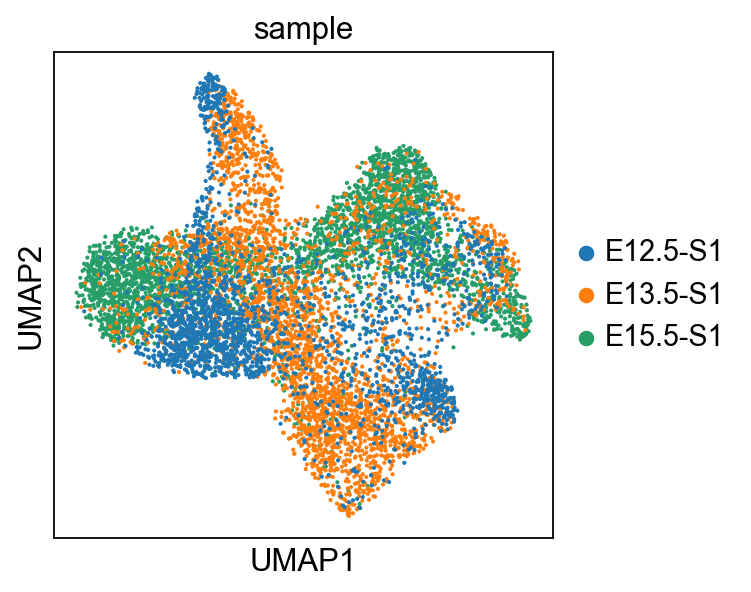

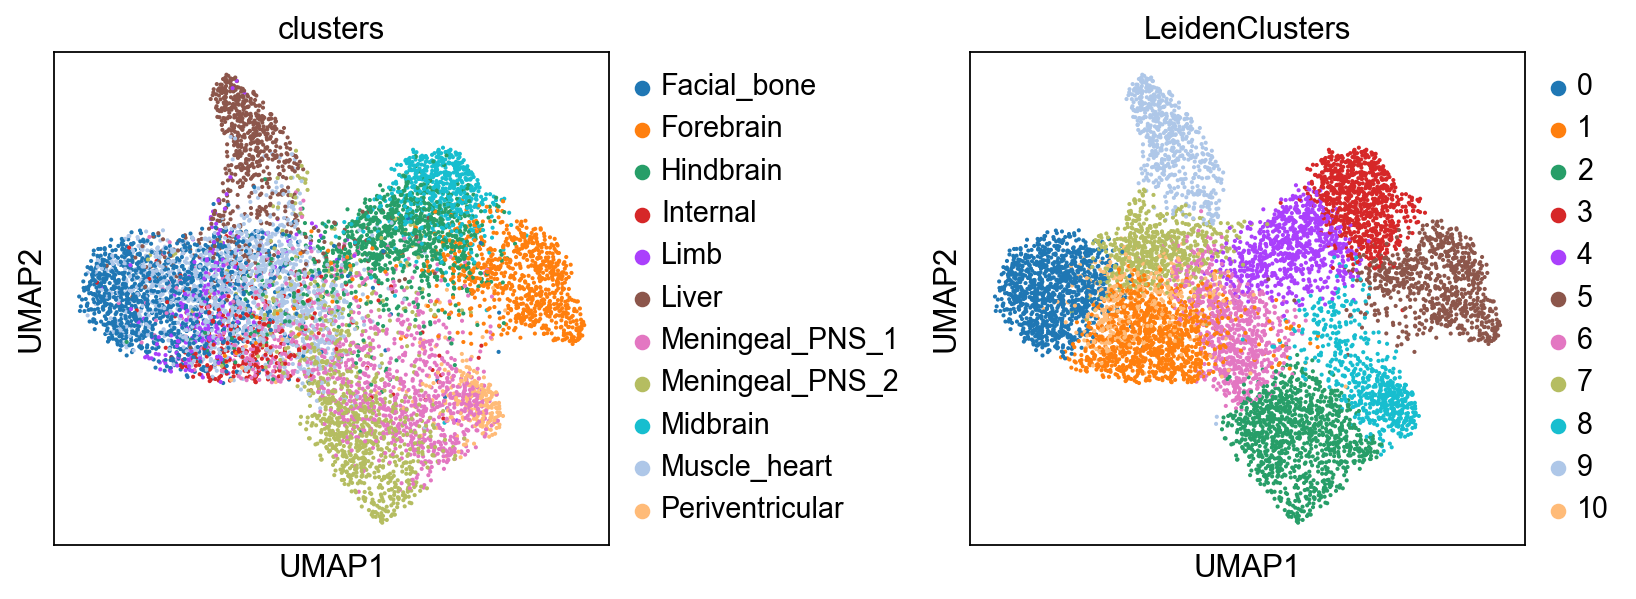

In [4]:
sc.pp.neighbors(adata, use_rep="embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")
sc.pl.umap(adata, color=["clusters", "LeidenClusters"], wspace=0.5)